In [155]:

import numpy as np
import cv2
import os
import sys
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import training_temp
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd


In [156]:
# Hyperparameters and settings
batch_size = 64
test_batch_size = 64
input_size = 1 # because there is only one channel 
output_size = 4
num_epochs = 10
learning_rate = 0.001



In [157]:
# Load training, validation and training data

data_loader = torch.load('data_loader.pt')
valid_loader = torch.load('valid_loader.pt')
test_loader = torch.load('test_loader.pt')


In [158]:
# load model architectures
model1 = training_temp.CNN()
model2 = training_temp.CNN2()
model3 = training_temp.CNN3()



In [159]:
#load the weights of the models
model1.load_state_dict(torch.load('CNN.pth'))
model2.load_state_dict(torch.load('CNN2.pth'))
model3.load_state_dict(torch.load('CNN3.pth'))

<All keys matched successfully>

In [160]:
# make confusion matrix based on test results
def confusion_matrix_data(model, test_loader):
    model.eval()
    predictions = []
    actual_labels = []
    f1_list = []
    recall_list = []
    precision_list = []
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.numpy())
            actual_labels.extend(labels.numpy())
        # print(predictions)
        # print(actual_labels)

    return predictions, actual_labels

In [161]:
def calculate_model_performance_stats(model, test_loader):
    data_out = {}

    predictions, actual_labels = confusion_matrix_data(model, test_loader)

    data_out['name'] = model.name
    data_out['predictions'] = predictions
    data_out['actual_labels'] = actual_labels
    data_out['f1_macro'] = sklearn.metrics.f1_score(actual_labels, predictions, average='macro')
    data_out['f1_micro'] = sklearn.metrics.f1_score(actual_labels, predictions, average='micro')
    data_out['recall_macro'] = sklearn.metrics.recall_score(actual_labels, predictions, average='macro')
    data_out['recall_micro'] = sklearn.metrics.recall_score(actual_labels, predictions, average='micro')
    data_out['precision_macro'] = sklearn.metrics.precision_score(actual_labels, predictions, average='macro')
    data_out['precision_micro'] = sklearn.metrics.precision_score(actual_labels, predictions, average='micro')
    data_out['accuracy'] = sklearn.metrics.accuracy_score(actual_labels, predictions)
    

    cf_matrix = sklearn.metrics.confusion_matrix(actual_labels, predictions)
    classes = {'focused': 0, 'happy': 1, 'neutral': 2, 'surprised': 3}
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [key for key in classes],
                        columns = [key for key in classes])

    plt.figure(figsize = (12,7))
    #set labels

    # https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
    #add label to heatmap
    plt.title('Confusion Matrix')
    sn.heatmap(df_cm, annot=True).set(xlabel='Predicted', ylabel='Actual')
    plt.savefig('matrix_%s.png'%(model.name))
    return data_out


Macro precision for :  CNN 0.9173425536257943
Micro precision for :  CNN 0.9114754098360656
Macro recall for :  CNN 0.9144411224379525
Micro recall for :  CNN 0.9114754098360656
Macro F1 for :  CNN 0.9141075239257525
Micro F1 for :  CNN 0.9114754098360656
Accuracy for :  CNN 0.9114754098360656
///////

Macro precision for :  CNN2 0.9190609903381642
Micro precision for :  CNN2 0.9081967213114754
Macro recall for :  CNN2 0.9113446021396924
Micro recall for :  CNN2 0.9081967213114754
Macro F1 for :  CNN2 0.9111379317901058
Micro F1 for :  CNN2 0.9081967213114754
Accuracy for :  CNN2 0.9081967213114754
///////

Macro precision for :  CNN3 0.9203113640688353
Micro precision for :  CNN3 0.9147540983606557
Macro recall for :  CNN3 0.9186442611337247
Micro recall for :  CNN3 0.9147540983606557
Macro F1 for :  CNN3 0.9171284902206218
Micro F1 for :  CNN3 0.9147540983606557
Accuracy for :  CNN3 0.9147540983606557
///////



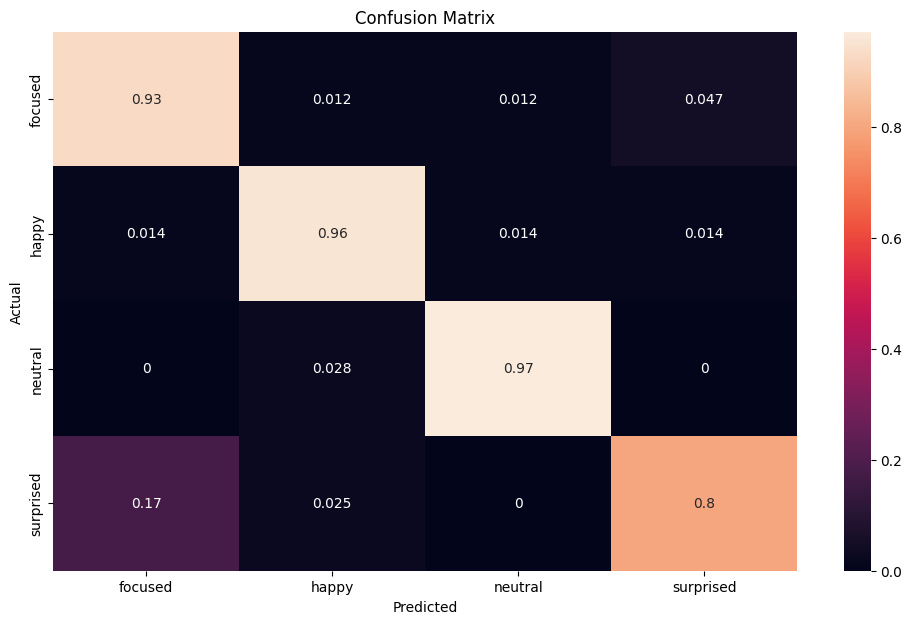

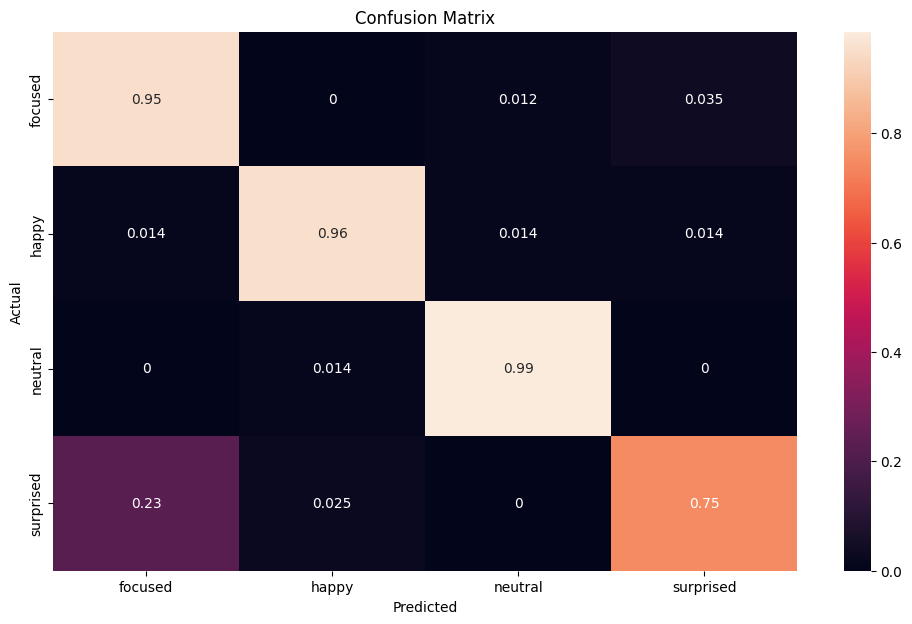

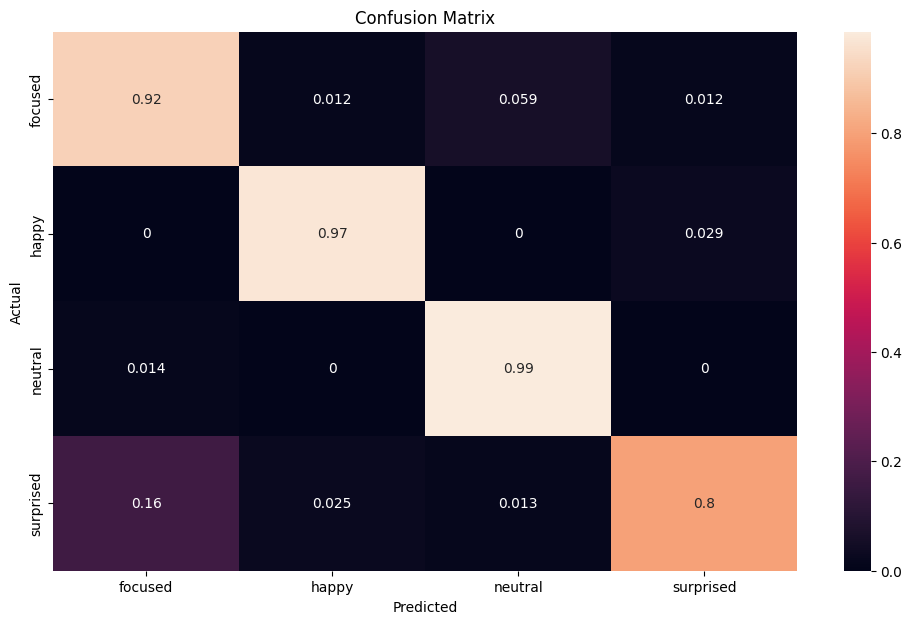

In [162]:
data_dicts = {'name': [], 'precision_micro': [], 'precision_macro': [], 'recall_micro': [], 'recall_macro': [], 'f1_micro': [], 'f1_macro': [], 'accuracy': []}
for model in [model1, model2, model3]:
    data_out = calculate_model_performance_stats(model, test_loader)
    print("Macro precision for : ", model.name, data_out['precision_macro'])
    print("Micro precision for : ", model.name, data_out['precision_micro'])
    print("Macro recall for : ", model.name, data_out['recall_macro'])
    print("Micro recall for : ", model.name, data_out['recall_micro'])
    print("Macro F1 for : ", model.name, data_out['f1_macro'])
    print("Micro F1 for : ", model.name, data_out['f1_micro'])
    print("Accuracy for : ", model.name, data_out['accuracy'])
    print("///////\n")

    for key in data_dicts.keys():
        data_dicts[key].append(data_out[key])

In [163]:
#make pandas dataframe
df = pd.DataFrame(data_dicts)

#set index to "name" column
df = df.set_index('name', inplace=False)

#reorder columns
df = df[['precision_macro', 'recall_macro', 'f1_macro', 'precision_micro', 'recall_micro', 'f1_micro', 'accuracy']]




In [164]:
display(df)

,precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro,accuracy
name,,,,,,,
CNN,0.917343,0.914441,0.914108,0.911475,0.911475,0.911475,0.911475
CNN2,0.919061,0.911345,0.911138,0.908197,0.908197,0.908197,0.908197
CNN3,0.920311,0.918644,0.917128,0.914754,0.914754,0.914754,0.914754


In [165]:
df.to_csv("evaluation_stats.csv")